<a href="https://colab.research.google.com/github/Mubasshir-Ali/Deep_Learning_Practice/blob/master/31_NLP_LSTM_With_Reviews_Subwords_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using LSTMs With The Subwords Dataset

# Import TensorFlow And Related Functions

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get The Dataset
We're going to use a dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative).

In [0]:
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

--2020-05-08 07:15:44--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.143.113, 74.125.143.102, 74.125.143.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.143.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/02ar2ukan1stbra30ikrhlmj13u1bebj/1588922100000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-05-08 07:15:44--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/02ar2ukan1stbra30ikrhlmj13u1bebj/1588922100000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 172.217.218.132, 2a00:1450:4013:c08::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|172.2

In [0]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [0]:
# Print some example sentences and labels
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




# Create A Subwords Dataset
We can use the existing Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality. SubwordTextEncoder.build_from_corpus() will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

The Amazon and Yelp dataset we are using isn't super large, so we'll create a subword vocab_size of only the 1,000 most common words, as well as cutting off each subword to be at most 5 characters.

In [0]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length = 5)

# How big is the vocab size?
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [0]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


# Replace Sentence Data With Encoded Subwords
Now, we'll re-create the dataset to be used for training by actually encoding each of the individual sentences. This is equivalent to text_to_sequences with the Tokenizer we used in earlier exercises.

In [0]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [0]:
# Check the sentences are appropriately replaced
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


# Final Pre-Processing
Before training, we still need to pad the sequences, as well as split into training and test sets.

In [0]:
import numpy as np

max_length = 50
trunc_type = 'post'
padding_type = 'post'

# Pad all sentences
sequences_padded = pad_sequences(sentences, maxlen = max_length, 
                                 padding = padding_type, truncating = trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0: training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0: training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Create The Model Using An Embedding

In [0]:
embedding_dim = 16

model = tf.keras.Sequential([
   tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), 
   tf.keras.layers.GlobalAveragePooling1D(), 
   tf.keras.layers.Dense(6, activation  = 'relu'), 
   tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


# Train The Model

In [0]:
num_epochs = 30
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs = num_epochs, validation_data = (testing_sequences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5499 - val_loss: 0.6924 - val_accuracy: 0.5338
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.6428 - val_loss: 0.6908 - val_accuracy: 0.5689
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.6830 - val_loss: 0.6880 - val_accuracy: 0.7043
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.7382 - val_loss: 0.6844 - val_accuracy: 0.6792
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.7640 - val_loss: 0.6768 - val_accuracy: 0.7293
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6649 - accuracy: 0.7640 - val_loss: 0.6649 - val_accuracy: 0.7368
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.7997 - val_loss: 0.6449 - val_accuracy: 0.7544
Epoch 8/30
50/50 [==

# Plot The Accuracy And Loss

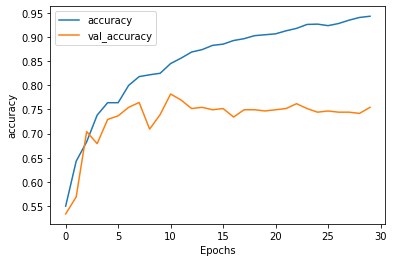

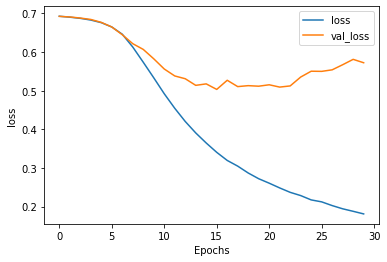

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' +string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' +string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Define A Function To Predict The Sentiment Of Reviews
We'll be creating models with some differences and will use each model to predict the sentiment of some new reviews.

To save time, create a function that will take in a model and some new reviews, and print out the sentiment of each reviews.

The higher the sentiment value is to 1, the more positive the review is.

In [0]:
# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen = max_length, show_padded_sequence = True):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type = 'post'
  padding_type = 'post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen = max_length, 
                                    padding = padding_type, truncating = trunc_type)
  
  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_sentences[x])
      # Print its predicted class
      print(classes[x])
      print("\n")


In [0]:
# Use the model to predict some reviews 
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)

I love this phone
[0.8650132]


Everything was cold
[0.08878242]


Everything was hot exactly as I wanted
[0.27710795]


Everything was green
[0.07354216]


the host seated us immediately
[0.41572183]


they gave us free chocolate cake
[0.64965737]


we couldn't hear each other talk because of the shouting in the kitchen
[0.01355633]




# Define A Function To Train And Show The Results Of Models With Different Layers
In the rest of this colab, we will define models, and then see the results.

Define a function that will take the model, compile it, train it, graph the accuracy and loss, and then predict some results.

In [0]:
def fit_model_now (model, sentences):
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs = num_epochs, 
                      validation_data = (testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results(model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

# Add A Bidirectional LSTM
Create a new model that uses a bidirectional LSTM.

Then use the function we have already defined to compile the model, train it, graph the accuracy and loss, then predict some results.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 1s 20ms/step - loss: 0.6928 - accuracy: 0.5066 - val_loss: 0.6952 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 0.6812 - accuracy: 0.5223 - val_los

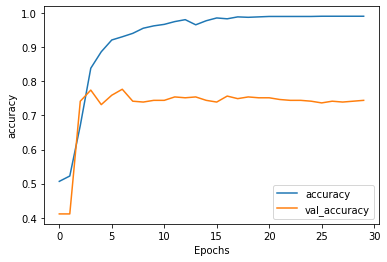

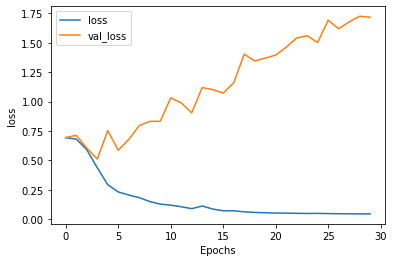

I love this phone
[0.999587]


Everything was cold
[0.02107972]


Everything was hot exactly as I wanted
[0.85701853]


Everything was green
[0.02605643]


the host seated us immediately
[0.99958915]


they gave us free chocolate cake
[0.9996424]


we couldn't hear each other talk because of the shouting in the kitchen
[0.01357611]




In [0]:
model_bidi_lstm = tf.keras.Sequential([
   tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), 
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
   tf.keras.layers.Dense(6, activation  = 'relu'), 
   tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)

# Use Multiple Bidirectional Layers
Now let's see if we get any improvements from adding another Bidirectional LSTM layer to the model.

Notice that the first Bidirectionl LSTM layer returns a sequence.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
dense_6 (Dense)              (None, 50, 6)             198       
_________________________________________________________________
dense_7 (Dense)              (None, 50, 1)             7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 1s 22ms/step - loss: 0.6919 - accuracy: 0.5312 - val_loss: 0.7044 - val_accuracy: 0.4122
Epoch 2/30
50/50 [==============================] - 0s 10ms/step - loss: 0.6851 - accuracy: 0.5722 - val_lo

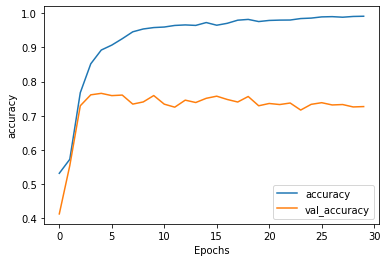

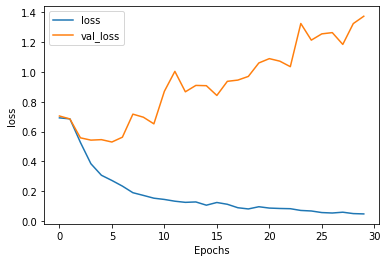

I love this phone
[[0.95558155]
 [0.9984529 ]
 [0.9587265 ]
 [0.9682594 ]
 [0.9931445 ]
 [0.99560815]
 [0.99713695]
 [0.9981115 ]
 [0.99873227]
 [0.99912876]
 [0.99938357]
 [0.99954873]
 [0.99965703]
 [0.999729  ]
 [0.9997775 ]
 [0.99981064]
 [0.99983335]
 [0.9998492 ]
 [0.99986005]
 [0.99986756]
 [0.9998723 ]
 [0.9998752 ]
 [0.9998765 ]
 [0.9998765 ]
 [0.9998754 ]
 [0.9998735 ]
 [0.9998708 ]
 [0.9998673 ]
 [0.999863  ]
 [0.99985826]
 [0.9998528 ]
 [0.9998467 ]
 [0.99984   ]
 [0.99983275]
 [0.99982506]
 [0.9998167 ]
 [0.9998078 ]
 [0.9997985 ]
 [0.9997887 ]
 [0.99977857]
 [0.9997682 ]
 [0.9997577 ]
 [0.9997472 ]
 [0.9997371 ]
 [0.9997274 ]
 [0.9997185 ]
 [0.99971086]
 [0.99970466]
 [0.9997004 ]
 [0.9996984 ]]


Everything was cold
[[0.0118757 ]
 [0.01019854]
 [0.01943267]
 [0.01692726]
 [0.02043315]
 [0.0245499 ]
 [0.01231926]
 [0.02652096]
 [0.02537929]
 [0.0214262 ]
 [0.01816314]
 [0.01547275]
 [0.01327441]
 [0.01150029]
 [0.0100867 ]
 [0.00897384]
 [0.00810755]
 [0.00744089]
 [0.006

In [0]:
model_multiple_bidi_lstm = tf.keras.Sequential([
   tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), 
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                      return_sequences = True)), 
   tf.keras.layers.Dense(6, activation  = 'relu'), 
   tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

# Compare Predictions For All The Models
It can be hard to see which model gives a better prediction for different reviews when you examine each model separately. So for comparison purposes, here we define some more reviews and print out the predictions that each of the three models gives for each review:

* Embeddings and a Global Average Pooling layer
* Embeddings and a Bidirectional LSTM layer
* Embeddings and two Bidirectional LSTM layers

The results are not always what you might expect. The input dataset is fairly small, it has less than 2000 reviews. Some of the reviews are fairly short, and some of the short ones are fairly repetitive which reduces their impact on improving the model, such as these two reviews:

* Bad Quality.
* Low Quality.

Feel free to add more reviews of your own, or change the reviews. The results will depend on the combination of words in the reviews, and how well they match to reviews in the training set.

How do the different models handle things like "wasn't good" which contains a positive word (good) but is a poor review?

In [0]:
my_reviews = ["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [0]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence = False)

 Embeddings only:


In [0]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence = False)

 With a single bidirectional LSTM:


In [0]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence = False)

 With two bidirectional LSTMs:
